In [83]:
import bhnerf
from astropy import units
import jax

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from flax.training import checkpoints
from pathlib import Path
import ruamel.yaml as yaml
import warnings
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib import animation

os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
warnings.simplefilter("ignore")

Visualize / aggregate recovery results
---
This notebook only loades previously saved checkpoints and aggregates the $\chi^2$ across inclination. \
The tomographic recovery needs to be pre-run with the script: `Fit_ALMA_LP_Apr11_SgrA_Flare.py`

In [95]:
def plot_chi2(df, xticks, figsize=(5,4), latex=True):
    if latex: 
        plt.rcParams.update({"text.usetex": True, 'font.family': 'lmodern'})
    plt.figure(figsize=figsize)
    plt.errorbar(df.index, np.nanmean(np.log10(df), axis=1), np.nanstd(np.log10(df), axis=1), color='tab:orange', marker='^', mfc='r', mec='r', markersize=5)
    plt.title(r'Inclination data-fit: $\log \chi^2(\theta | {\bf w}^\star)$', fontsize=16)
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.axhline(0, color='black', linestyle='--',linewidth=0.75)
    plt.xticks(xticks);

def render_mean_images(seeds, inclinations, t_frames, t_start_obs, norm_const, fov, bh_radius, view_zeniths, 
                       view_azimuths, resolution, cam_r, linewidth, chunk=32, jit=False):
    rot_sign = {'cw': -1, 'ccw': 1}
    images = []
    seeds = np.atleast_1d(seeds)
    inclinations = np.atleast_1d(inclinations)
    visualizer = bhnerf.visualization.VolumeVisualizer(resolution, resolution, resolution)
    for zenith in tqdm(np.atleast_1d(view_zeniths), desc='view zenith', leave=False):
        for azimuth in tqdm(np.atleast_1d(view_azimuths), desc='view azimtuh', leave=False):
            for t in tqdm(np.atleast_1d(t_frames), desc='t', leave=False):
                emission = 0
                visualizer.set_view(cam_r=cam_r, domain_r=fov/2.0, azimuth=azimuth, zenith=zenith)
               
                # Keplerian velocity
                if t != t_start_obs:
                    r = np.sqrt(visualizer.coords[0]**2 + visualizer.coords[1]**2 + visualizer.coords[2]**2)
                    Omega = rot_sign[Omega_dir] * np.sqrt(1) / (r**(3/2) + spin * np.sqrt(1))
                else:
                    Omega = 0.0

                for inc in tqdm(inclinations, desc='inc', leave=False):
                    for seed in tqdm(seeds, desc='seed', leave=False):
                        checkpoint_dir = recovery_path.joinpath(basename.format(inc, seed))
                        emission += (1/(len(seeds)*len(inclinations))) * bhnerf.network.sample_checkpoint_3d(
                            checkpoint_dir, t, t_start_obs, Omega, coords=visualizer.coords, chunk=chunk
                        )
                    
                image = visualizer.render(emission / norm_const, facewidth=1.9*fov/2.0, jit=jit, bh_radius=bh_radius, linewidth=linewidth).clip(max=1)
                images.append(image)
    return images

In [ ]:
seed = 0
inclination = 12.0

basename = 'inc_{:.1f}.seed_{}'
recovery_path = Path('../checkpoints/alma/intrinsic_fits/vertical_b_variable_pixels1/')
checkpoint_dir = recovery_path.joinpath(basename.format(inclination, seed))
outpath = Path(os.path.join(*recovery_path.parts[2:]))
outpath.mkdir(parents=True, exist_ok=True)

with open(recovery_path.joinpath('config.yml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

locals().update(config['preprocess'])
locals().update(config['model'])
train_split = config['optimization']['train_split']
sigma = config['optimization']['sigma']

# Preprocess / split data to train/validation
target, t_frames = bhnerf.alma.preprocess_data(**config['preprocess'])
train_idx = t_frames <= t_start*units.hr + train_split*units.min
t_train, data_train  = t_frames[train_idx], target[train_idx]
rot_angle = np.deg2rad(de_rot_angle + 20.0)

# Inclination $\chi^2$
---
Compute the data-fit as a function of inclination angle: $\chi^2\left(\theta_o\right)$

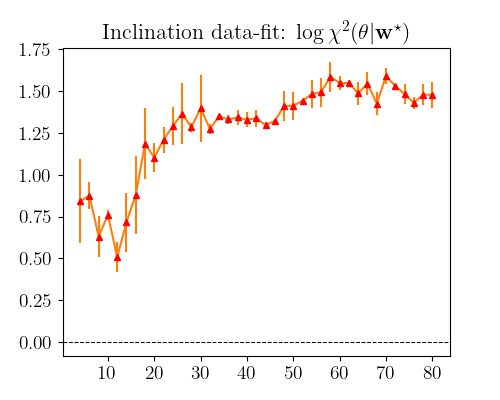

In [23]:
"""
Compute a chi2 over a set of random subpixel rays. 
This enables better generalization across different model parameters.
"""
num_subrays = 10
seeds = range(4)
inclinations = np.arange(4, 82, 2, dtype=float)

checkpoint_fmt = str(recovery_path.joinpath('inc_{:.1f}.seed_{}'))
chi2_inc = bhnerf.alma.chi2_df(
    inclinations, spin, seeds, config['model'], checkpoint_fmt, t_train, data_train, 
    sigma=sigma, rot_angle=rot_angle, num_subpixel_rays=num_subrays
)
chi2_inc.to_csv(recovery_path.joinpath('inclination_loss_subrays_{}.csv'.format(num_subrays)))

%matplotlib widget
plot_chi2(chi2_inc, xticks=range(10,90,10))

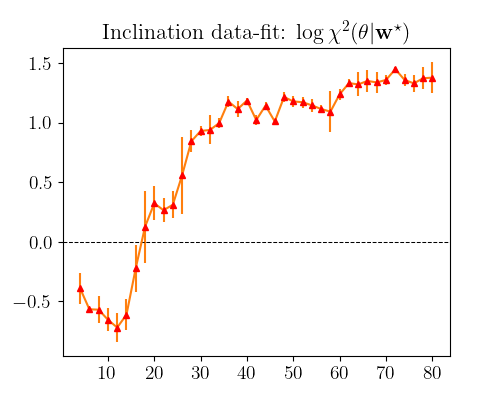

In [19]:
"""
Compute a chi2 over a fixed set of rays
"""
seeds = range(4)
inclinations = np.arange(4, 82, 2, dtype=float)
checkpoint_fmt = str(recovery_path.joinpath('inc_{:.1f}.seed_{}'))
chi2_inc = bhnerf.alma.chi2_df(inclinations, spin, seeds, config['model'], checkpoint_fmt, t_train, data_train, sigma=sigma, rot_angle=rot_angle)
chi2_inc.to_csv(recovery_path.joinpath('inclination_loss.csv'))

%matplotlib widget
plot_chi2(chi2_inc)

# Spin $\chi^2$
---
Compute the data-fit as a function of spin: $\chi^2\left(a\right)$

(-0.1, 2.0)

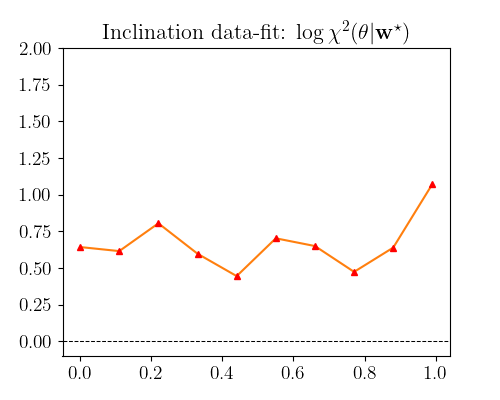

In [38]:
"""
Compute a chi2 over a set of random subpixel rays. 
This enables better generalization across different model parameters.
"""
num_subrays = 10
seeds = range(4)
spins = np.linspace(1e-3, 0.99, 10)

checkpoint_fmt = str(recovery_path.joinpath('spin_{:.1f}.seed_{}'))
chi2_inc = bhnerf.alma.chi2_df(
    inclination, spins, seeds, config['model'], checkpoint_fmt, t_train, data_train, 
    sigma=sigma, rot_angle=rot_angle, num_subpixel_rays=num_subrays
)
chi2_inc.to_csv(recovery_path.joinpath('spin_loss_subrays_{}.csv'.format(num_subrays)))

%matplotlib widget
plot_chi2(chi2_inc, xticks=np.linspace(0,1,6))
plt.ylim(-0.1, 2)

# 3D volume
---
Visualize the 3D recovery 

In [5]:
resolution = 64
emission = bhnerf.network.sample_checkpoint_3d(checkpoint_dir, fov=fov_M, resolution=resolution)
bhnerf.visualization.ipyvolume_3d(emission, fov=fov_M, level=[0.1, .2, 0.6])

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

## Custom renderer, for consistent plotting
Render and animate recovered 3D volumes. \
Takes more time to render with the costum renderer.

In [60]:
seeds = range(5)
inclinations = 12

renderer_params = {
    'resolution': 256,
    'cam_r': 55.,
    'fov': fov_M,
    'linewidth': 0.14,
    'norm_const': 0.05,
    'bh_radius': 1 + np.sqrt(1-spin**2),
    't_frames': 0,
    't_start_obs':0,
    'view_zeniths': [np.deg2rad(35), np.deg2rad(65)],
    'view_azimuths': 0.0
}

images = render_mean_images(seeds, inclinations, **renderer_params, jit=False)

view angle:   0%|          | 0/2 [00:00<?, ?it/s]

view angle:   0%|          | 0/1 [00:00<?, ?it/s]

inc:   0%|          | 0/1 [00:00<?, ?it/s]

seed:   0%|          | 0/5 [00:00<?, ?it/s]

view angle:   0%|          | 0/1 [00:00<?, ?it/s]

inc:   0%|          | 0/1 [00:00<?, ?it/s]

seed:   0%|          | 0/5 [00:00<?, ?it/s]

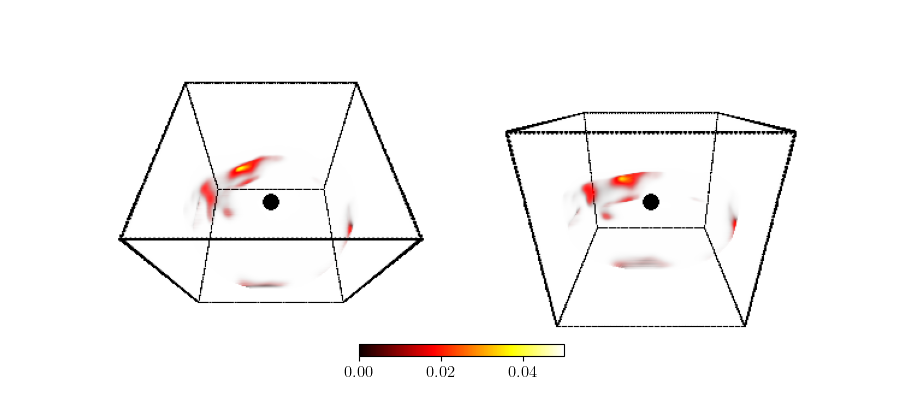

In [62]:
fig, axes = plt.subplots(1, len(images), figsize=(9,4))
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.set_axis_off()

ax = fig.add_subplot(132)
ax.set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='3%', pad=-1)
cmap = plt.cm.ScalarMappable(norm=Normalize(0, renderer_params['norm_const'], clip=True), cmap=plt.get_cmap('hot'))
cbar = fig.colorbar(cmap, cax=cax, orientation='horizontal', shrink=.0)
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

outformat = '3D_Recovery_seeds_{}_incs_{}.pdf'
outname = outformat.format(
    '-'.join([str(seed) for seed in np.atleast_1d(seeds)]),
    '-'.join([str(int(inc)) for inc in np.atleast_1d(inclinations)])
)
plt.savefig(outpath.joinpath(outname), bbox_inches='tight')

# Datafit
---
visualize light curve data fit

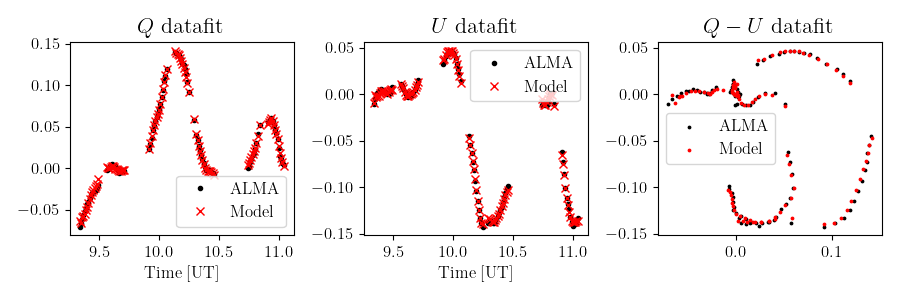

In [19]:
batchsize = 20
raytracing_args = bhnerf.alma.get_raytracing_args(np.deg2rad(inclination), spin, config['model'], rot_angle=rot_angle)
image_plane = bhnerf.network.image_plane_checkpoint(raytracing_args, checkpoint_dir, t_train, batchsize=batchsize)
model = image_plane.sum(axis=(-1,-2))

%matplotlib widget
plt.rcParams.update({"text.usetex": True, 'font.family': 'lmodern'})
axes = bhnerf.visualization.plot_stokes_lc(data_train[:,1:], ['Q','U'], t_train, label='ALMA', color='black', plot_qu=True)
bhnerf.visualization.plot_stokes_lc(model[:,1:], ['Q','U'], t_train, axes=axes, color='r', fmt='x', label='Model', plot_qu=True)

titles = [r'$Q$ datafit', r'$U$ datafit', r'$Q-U$ datafit']
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=16)
    ax.legend()
    
axes[0].set_xlabel('Time [UT]', fontsize=12)
axes[1].set_xlabel('Time [UT]', fontsize=12)
plt.tight_layout()

savepath = outpath.joinpath(basename.format(inclination, seed))
savepath.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath.joinpath('QU_datafit.pdf'), bbox_inches='tight')